Copyright 2024 Zhixuan Hu

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

#### 计算各项指标和导出pth

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, json, time, random, types
import torch
import torch.nn as nn               # 用于继承的模型都在这里
import torch.nn.functional as F     # 常用的激活函数、损失函数等
from torchsummary import summary    # 用于模型总结
from torch.utils.collect_env import get_pretty_env_info
from dtools import select_device, Controller, Marker
os.chdir('./')                      # 设定工作根目录
env_info = get_pretty_env_info()    # 获取硬件、操作系统、pytorch版本等env信息
device, device_name = select_device()   # device是对象，device_name是设备名称
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

class LiHuNet(nn.Module):
    def __init__(self):     # 初始化
        super().__init__() # init父类
        ## 构建全连接层
        self.fc = nn.Sequential(
            nn.Linear(1536 * 2, 816), 
            nn.ReLU(),
            nn.Linear(816, 256),
            nn.ReLU(),
            nn.Linear(256, 1), 
            nn.Sigmoid()
        ) # 注意这里只进行了线性变换，没有接softmax变换，这是因为随后的损失函数中包含了softmax操作。

    def forward(self, x):
        x = x.to(device)       # 前向传播
        output = self.fc(x.view(x.size()[0], -1))
        return output

Intel(R) Arc(TM) Graphics selected.


In [3]:
d_embedding_model = 'text-embedding-3-small'

d_train_pct = 0.7     # 默认参数：训练集与验证集7:3
d_batch_size = 32     # 默认参数：一个epoch有32个样本
d_num_workers = 0     # 默认参数：同时工作0个进程的取数器
d_embedding_size = 1536 * 2        # 默认参数：图片长宽均为128
# d_transform = transforms.Compose([                    # 默认的预处理
#     transforms.Resize((default_imsize, default_imsize)),   
#     transforms.ToTensor(),                                  
# ])

def default_loader(embedding:str):       
    return torch.tensor(json.loads(embedding))

class DataSet():

    def __init__(self, qhafiles: list=None, embedding_model: str=d_embedding_model, from_cached: list=None, loader: types.FunctionType=default_loader, transform=None):

        if from_cached != None:
            dfs = [pd.read_csv(file) for file in from_cached]
            self.data = pd.concat(dfs).sample(frac=1).reset_index(drop=True)

            if len(dfs) > 1:
                time_str = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
                self.data.to_csv(f'cached_dataset/merged-{time_str}')
                
            self.data[['question', 'answer']] = self.data[['question', 'answer']].map(loader)

        else:
            self.embedding_model = embedding_model
            self.loader = loader
            self.transform = transform

            self.qhadfs = []
            for qfile, hfile, afile in qhafiles:
                self.qhadfs.append((pd.read_csv(qfile), pd.read_csv(hfile), pd.read_csv(afile)))
            
            self.data = pd.DataFrame()
            for qdf, hdf, adf in self.qhadfs:
                qdf = qdf[['question_id', self.embedding_model]].rename(columns={self.embedding_model: 'question'})
                hdf = hdf[['question_id', self.embedding_model]].rename(columns={self.embedding_model: 'answer'})
                adf = adf[['question_id', self.embedding_model]].rename(columns={self.embedding_model: 'answer'})
                hdf = pd.merge(hdf, qdf, on='question_id', how='left').assign(label=0.0).drop(columns=['question_id'])
                adf = pd.merge(adf, qdf, on='question_id', how='left').assign(label=1.0).drop(columns=['question_id'])
                self.data = pd.concat([self.data, hdf, adf]).sample(frac=1).reset_index(drop=True)
            
            # 保存这个数据集，便于复现
            time_str = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
            self.data.to_csv(f'cached_dataset/test-{time_str}')
            self.data[['question', 'answer']] = self.data[['question', 'answer']].map(loader)

    def __len__(self):                  # 用于度量一批图片的数量
        return len(self.data)

    def __getitem__(self, index):       # 用于取出一批图片
        item = self.data.iloc[index]
        question = item['question']
        answer = item['answer']
        label = torch.tensor([item['label']], dtype=torch.float32)
        return torch.cat((question, answer), dim=0), label     

    def split(self, train_pct=d_train_pct):   # 用于按train_pct的比例切分训练集和验证集
        train_size = int(len(self) * train_pct)     # 训练集样本数
        valdate_size = len(self) - train_size       # 验证集样本数
        self.train_set, self.validate_set = torch.utils.data.random_split(self, [train_size, valdate_size]) # 切分
        return (self.train_set, self.validate_set)  # 返回切分后的样本

    def loaders(self, batch_size=d_batch_size, num_workers=d_num_workers):  # 多进程返回训练集数据生成器和验证集数据生成器
        self.train_loader = torch.utils.data.DataLoader(self.train_set, 
                                                   batch_size=batch_size, shuffle=True, num_workers=num_workers)    # 训练集打乱
        self.validate_loader = torch.utils.data.DataLoader(self.validate_set, 
                                                     batch_size=batch_size, shuffle=False, num_workers=num_workers) # 验证集不打乱
        return (self.train_loader, self.validate_loader)    


In [4]:
def evaluate(model, pth, validate_loader, savesvg):

    model.load_state_dict(pth)
    model.to(device)
    model.eval()

    # 存储所有预测和真实标签
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():  # 不计算梯度，节省内存和计算资源
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 获得模型的输出
            outputs = model(inputs).cpu()
            preds = torch.where(outputs > 0.5, torch.tensor(1, dtype=torch.int8), torch.tensor(0, dtype=torch.int8))
            
            # 将预测和标签保存到列表中
            all_probs.extend(outputs.numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算性能指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # 计算ROC曲线和AUC
    # 注意：这里假设你的任务是二分类问题
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(savesvg, format='svg', bbox_inches='tight')

#### 小样本训练，大样本测试

Accuracy: 0.6905077995353468
Precision: 0.6037289915966386
Recall: 0.8659133709981167
F1 Score: 0.7114343184279746


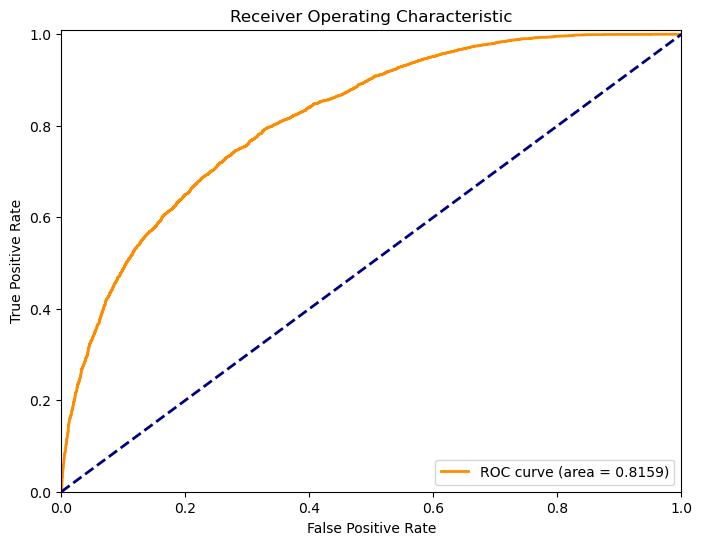

In [9]:
model = LiHuNet()
pth = torch.load('pths/LiHuNet3072-v1-test-dataset-240425004817.pth')
data = DataSet(from_cached=['cached_dataset/test-2024-05-07-17-17-41'])
data.split()
train_loader, val_loader = data.loaders(num_workers=0)
evaluate(model=model, pth=pth, validate_loader=val_loader, savesvg='ROC_smallmodel_on_bigtest.svg')

Accuracy: 0.7342349817457683
Precision: 0.6576317383403998
Recall: 0.821759697256386
F1 Score: 0.7305913028850197


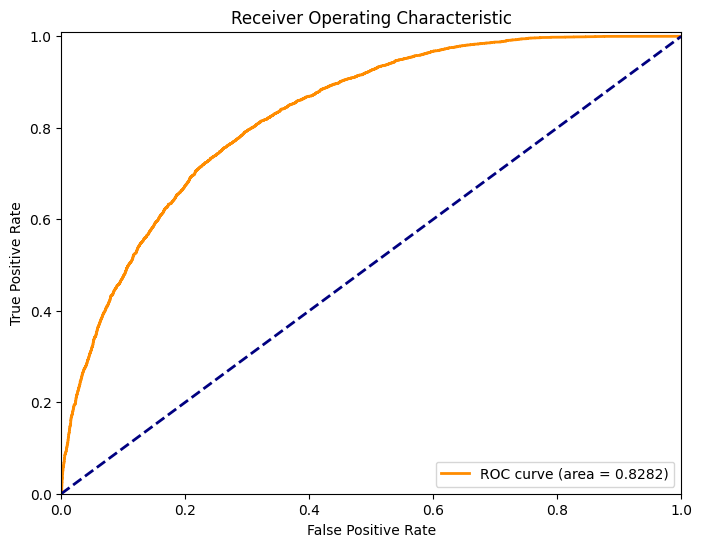

In [5]:
model = LiHuNet()
pth = torch.load('trainlog/2024-05-09-22-14-34/2024-05-09-22-14-42-Epoch-14.tar')['model_state_dict']
data = DataSet(from_cached=['cached_dataset/test-2024-05-07-17-17-41'])
data.split()
train_loader, val_loader = data.loaders(num_workers=0)
evaluate(model=model, pth=pth, validate_loader=val_loader, savesvg='ROC_smallmodel_on_bigtest1.svg')

#### 大样本训练，大样本测试

Accuracy: 0.9771822104215068
Precision: 0.9685863874345549
Recall: 0.9797616795914508
F1 Score: 0.9741419840150446


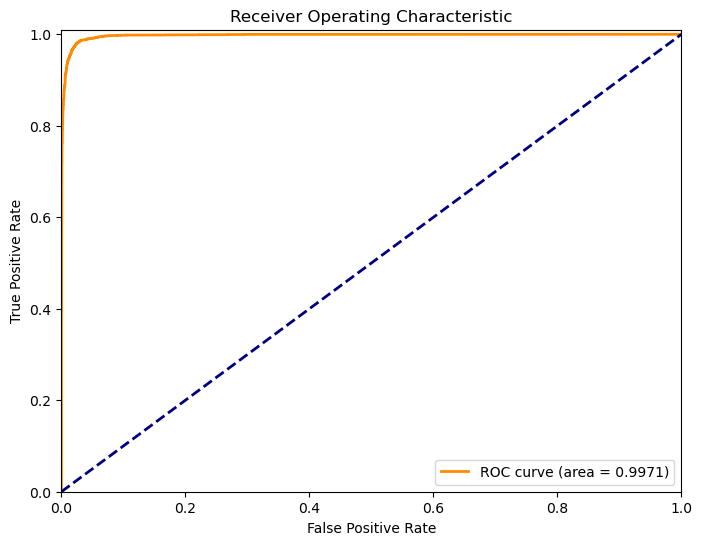

In [12]:
model = LiHuNet()
pth = torch.load('trainlog/2024-05-08-10-55-13/2024-05-08-10-56-36-Epoch-8.tar')['model_state_dict']
data = DataSet(from_cached=['cached_dataset/test-2024-05-07-17-17-41'])
data.split()
train_loader, val_loader = data.loaders(num_workers=0)
evaluate(model=model, pth=pth, validate_loader=val_loader, savesvg='ROC_bigmodel_on_bigtest.svg')

#### 小样本训练，小样本测试

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


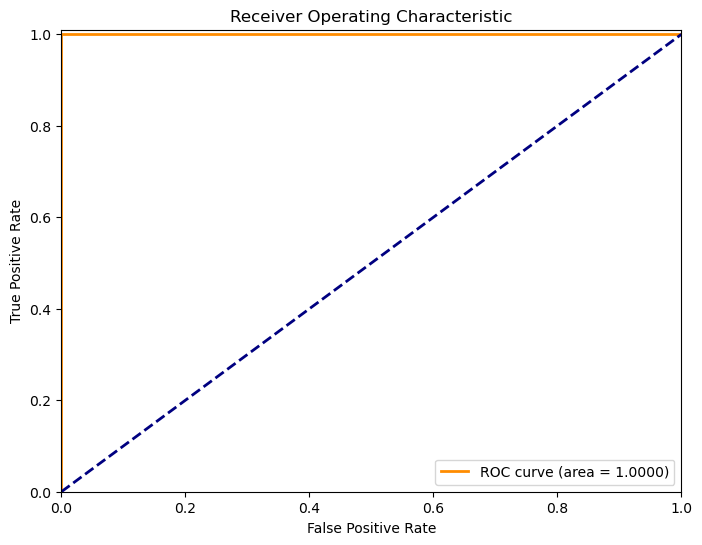

In [13]:
model = LiHuNet()
pth = torch.load('pths/LiHuNet3072-v1-test-dataset-240425004817.pth')
data = DataSet(from_cached=['cached_dataset/test-2024-04-25-00-47-22'])
data.split()
train_loader, val_loader = data.loaders(num_workers=0)
evaluate(model=model, pth=pth, validate_loader=val_loader, savesvg='ROC_smallmodel_on_smalltest.svg')

#### 大样本训练，小样本测试

Accuracy: 0.9829545454545454
Precision: 0.9903846153846154
Recall: 0.9809523809523809
F1 Score: 0.985645933014354


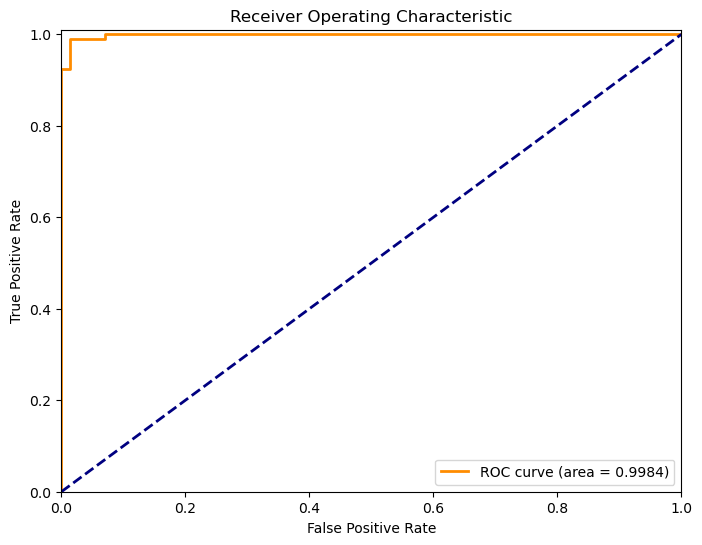

In [14]:
model = LiHuNet()
pth = torch.load('trainlog/2024-05-08-10-55-13/2024-05-08-10-56-36-Epoch-8.tar')['model_state_dict']
data = DataSet(from_cached=['cached_dataset/test-2024-04-25-00-47-22'])
data.split()
train_loader, val_loader = data.loaders(num_workers=0)
evaluate(model=model, pth=pth, validate_loader=val_loader, savesvg='ROC_bigmodel_on_smalltest.svg')

In [6]:
torch.save(pth, 'pths/LiHuNet3072-v1-turbo-flightqa-2405092221.pth')